# Multi-Label Classification

In [ ]:
# libraries
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras import initializers as initializers
from keras.preprocessing.text import Tokenizer
from keras.layers.embeddings import Embedding
from keras.layers import Bidirectional, GRU
from keras.engine.topology import Layer
from keras.optimizers import Adam
from keras import backend as K
from keras.layers import Dense
from keras.models import Model
from keras.layers import Input
from termcolor import colored

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk import tokenize
nltk.download('punkt')
import nltk

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gozdemervedemirci/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gozdemervedemirci/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# dataset
data = pd.read_csv("train.csv")

## Data EDA & Pre-Processing

In [ ]:
# NaN values
data.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

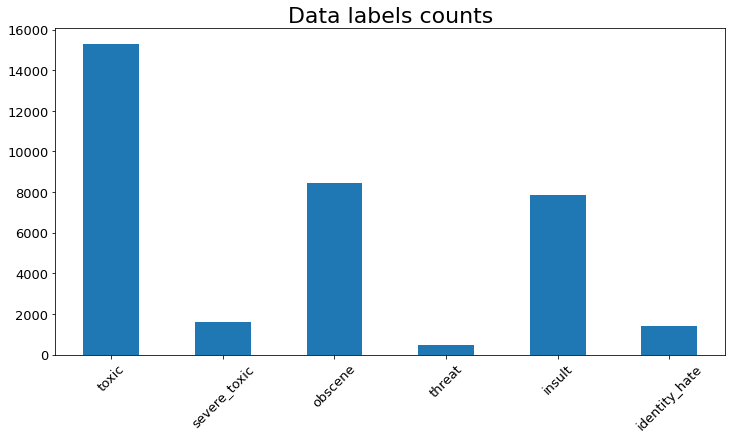

In [ ]:
# labels distribution
labels = data[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]

fig = plt.figure(figsize = (12, 6))
labels.sum(axis=0).plot.bar()
plt.xticks(fontsize = 13, rotation = 45)
plt.yticks(fontsize = 13)
plt.title("Data labels counts", fontsize = 22)
plt.show()

In [ ]:
# pre-processing
stop_words = set(stopwords.words('english'))

def preprocess_text(text):

    # removing numbers and symbols
    sentence = re.sub('[^a-zA-Z]', ' ', text)
    
    # removing single characters
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # removing special characters
    sentence = re.sub(r'[!”"#$%&’()*+,-./:;<=>?@[\]''^_`{|}~]','', sentence)
    
    # lowercase
    sentence = sentence.lower()
    
    # removing stopwords
    sentence = " ".join([item for item in sentence.split() if item not in stop_words])
    
    # lemmatizing
    lemmatizer = WordNetLemmatizer()
    sentence = " ".join([lemmatizer.lemmatize(item) for item in sentence.split()])
    
    return sentence

In [ ]:
# assign x and y data
X = data['comment_text'].apply(preprocess_text)
y = labels.values

## Application

### 1. Preparing X data

- Prepared the application by embedding the texts in the X data into numerical vectors. (embedding)

- Calculation of the parameters required for the application was made. (word count, max length, longest line, embedding size)

After these applications, X data will consist of numerical vectors (padding) with each row of the same size. Each special number refers to a word.

In [ ]:
all_words = ' '.join([i for i in list(X)]).split()
max_words = len(set(all_words))

word_counts = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(X, key=word_counts)
max_len = len(word_tokenize(longest_sentence))
embed_size = 100

tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)
padded_X = pad_sequences(X, padding='post', maxlen=max_len)

### 2. Creating the word embedding matrix

- GloVe (Global Vector) is used for word representation. GloVe is an algorithm that works with unsupervised learning. It is a library that is ready to calculate the vector relationship between words, together with the Pre-trained file.

GloVe pre-trained word vector is loaded into the application by file. GloVe .txt document has been sent to you by mail with the name "glove.6B.100d.txt".

<sub><sup>https://nlp.stanford.edu/projects/glove/</sup></sub>

In [ ]:
embeddings_dictionary = {}

with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        embed = np.asarray(values[1:], dtype='float32')
        embeddings_dictionary[word] = embed
        
print('Found {} word vectors.'.format(len(embeddings_dictionary)))
        
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size), dtype='float32')

for word, i in word_index.items():
    if i >= max_words:
        continue
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


### 3. Editing the model

Along with the previously found parameters, our application has density and layer values.

Since our aim will be label prediction over sentences, a two-way layer has been created as past and future. *Bidirectional*

Since the result output is 0 and 1 in multi-labels, the "sigmoid" function is taken in the activation.

***Attention Mechanism***

In order to find out from which related word the labels were selected in each line, a mechanism called *"Hierarchical Attention Network"* in the literature was used in the modeling. Here, while preparing the inputs and layers to be created for the model, the vector relationship between words is also taken into account. Thus, the relevant ***important*** word of the input text will be removed during testing and estimation.

In [ ]:
class AttentionLayer(Layer):
    """
    Hierarchial Attention Layer as described by Hierarchical Attention Networks for Document Classification(2016)
    - Yang et. al.
    Source: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
    Theano backend
    """

    def __init__(self,attention_dim=100,return_coefficients=False,**kwargs):
        # Initializer 
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform') # initializes values with uniform distribution
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)
        
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'return_coefficients': self.return_coefficients,
            "initializers.get('glorot_uniform')": self.init,
            'attention_dim': self.attention_dim,
            'True': self.supports_masking,
        })
        return config

    def build(self, input_shape):
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)),name='W')
        self.b = K.variable(self.init((self.attention_dim, )),name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)),name='u')
        self._trainable_weights = [self.W, self.b, self.u]

        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, hit, mask=None):
        # Here, the actual calculation is done
        uit = K.bias_add(K.dot(hit, self.W),self.b)
        uit = K.tanh(uit)
        
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)
        
        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), ait]
        else:
            return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]
    @classmethod
    def from_config(cls, config):
          return cls(**config)

In the input text, word-based layers were created, not sentence-based. Thus, the desired number of relevant **words** can be determined.

In [ ]:
x = Embedding(max_words, embed_size, weights=[embedding_matrix], trainable=False)

word_input = Input(shape=(max_len,),dtype='int32',name='word_input')
word_sequences = x(word_input)
word_gru = Bidirectional(GRU(128, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(word_sequences)
word_dense = Dense(6, activation='sigmoid', name='word_dense')(word_gru) 
word_att,word_coeffs = AttentionLayer(embed_size,True,name='word_attention')(word_dense)

model = Model(inputs = word_input,outputs = word_att)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_input (InputLayer)      [(None, 1250)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1250, 100)         15869700  
_________________________________________________________________
bidirectional (Bidirectional (None, 1250, 256)         176640    
_________________________________________________________________
word_dense (Dense)           (None, 1250, 6)           1542      
_________________________________________________________________
word_attention (AttentionLay [(None, 6), (None, 1250,  800       
Total params: 16,048,682
Trainable params: 178,982
Non-trainable params: 15,869,700
_________________________________________________________________


#### Dataset Splitting

In [ ]:
# verisetini bölme
X_train, X_test, y_train, y_test = train_test_split(padded_X, y, test_size=0.3, random_state=42)

### Model Fitting

In [ ]:
batch_size = 128
history = model.fit(X_train, y_train, validation_split=0.2, batch_size=batch_size, epochs=1)

699/699 [==============================] - 4173s 6s/step - loss: 0.0962 - accuracy: 0.9900 - val_loss: 0.0593 - val_accuracy: 0.9940


In [ ]:
loss, acc = model.evaluate(X_test,y_test)
print("Test set accuracy: ",acc)
print("Test set loss: ", loss)

1496/1496 [==============================] - 420s 281ms/step - loss: 0.0573 - accuracy: 0.9940
Test set accuracy:  0.9940466284751892
Test set loss:  0.057336051017045975


The accuracy rates of the model and test data are almost the same. I couldn't print out the epoch-accuracy and epoch-loss figures because it was fitted with 1 epoch. We could comment on whether there is an overfitting by looking here.

Considering the sigmoid function, as a result of the labels values greater than 0.5 are assigned values of 1 and those of less than 0 values.

After all the steps, estimation was made with the X_test data that we separated in the dataset. As a result, 99% accuracy was found. For a detailed illustration of the result, a random line, its estimates and actual values are given.

## Hierarchial Attention Network

After model fitting, we will now call the word attention mechanism and try it on the test.

In the function named karsilastirma(), by entering any number of lines (test_number) and the number of words assigned from the attention mechanism (n) in the X_test dataset, the text given in that line, the labels of that line, the predicted labels for that line, and the number of important and significant in that line. specified (n) *"highlighted"* words are given as output.

In [ ]:
def wordAttentionWeights(sequenceSentence,weights):
    """
    The same function as the AttentionLayer class.
    """
    uit = np.dot(sequenceSentence, weights[0]) + weights[1]
    uit = np.tanh(uit)

    ait = np.dot(uit, weights[2])
    ait = np.squeeze(ait)
    ait = np.exp(ait)
    ait /= np.sum(ait)
    
    return ait

def karsilastirma(test_no, n):
    text = tokenizer.sequences_to_texts([X_test[test_no]])
    summary_cleaned = preprocess_text(str(text))
    
    all_words = ' '.join([i for i in list(summary_cleaned)]).split()
    max_words = len(set(all_words))

    tokenizer_test = Tokenizer(num_words=max_words, lower=True)
    tokenizer_test.fit_on_texts(summary_cleaned)

    padded_x = tokenizer_test.texts_to_sequences(summary_cleaned)
    padded_text = pad_sequences(padded_x, padding='post', maxlen=max_len)

    hidden_word_encoding_out = Model(inputs=model.input, outputs=model.get_layer('word_dense').output)
    word_context = model.get_layer('word_attention').get_weights()
    hidden_word_encodings = hidden_word_encoding_out.predict(padded_text)
    ait = wordAttentionWeights(hidden_word_encodings,word_context)
    
    # Get n words with most attention in document
    n_words = n

    flattenlist = []
    words_unpadded = []
    for idx,sent in enumerate(tokenize.sent_tokenize(summary_cleaned)):
        attword_list = tokenize.word_tokenize(sent.rstrip('.'))
        ait_short = (1000*ait[idx][:len(attword_list)]).tolist()
        words_unpadded.extend(ait_short)
        flattenlist.extend(attword_list)


    words_unpadded = np.array(words_unpadded)
    sorted_wordlist = [flattenlist[i] for i in words_unpadded.argsort()]

    mostAtt_words = []
    i = 0
    for word in reversed(sorted_wordlist):
        if word not in mostAtt_words:
            mostAtt_words.append(word)
            i += 1
        if(i>=n_words):
            break
            
            
    prediction = model.predict(np.expand_dims(X_test[test_no], 0))
    prediction = np.where(prediction > 0.5, 1, 0)

    _, idx = np.where(prediction == 1)
    if idx.all == 0:
        etiket = "Hiçbir etiket uygun değil."
    else:
        etiket = labels.columns[idx]

    # text = tokenizer.sequences_to_texts([X_test[47846]])

    from termcolor import colored
    formattedText = []
    for t in str(text).split():
        if t in mostAtt_words:
            formattedText.append(colored(t,'white','on_red'))
        else: 
            formattedText.append(t)

    highlighted_text = " ".join(formattedText)
    
    print("Metin: ", highlighted_text)
    print("\nGerçek etiketleri sırasıyla:\t\t",y_test[47846])
    print("\nTahmin edilen etiketler: \t\t", prediction)
    print("\nCümleye göre etkili olduğu etiketler:\t", list(etiket))
    print("\nÖnemli kelimeler (5 kelime eşiği ile):\t", mostAtt_words)

---

Testing the 7887th row in the X_test dataset:

There will be 4 close words.

In [ ]:
karsilastirma(7887,4)

Metin:  ['give break calling guessing guessing saying law would suggest make year old girl test law swimmer hope cannot fathom defense yes child adi guessing committing crime guessing word someone like defending guessing talk page saini']

Gerçek etiketleri sırasıyla:		 [1 0 1 0 1 1]

Tahmin edilen etiketler: 		 [[1 0 0 0 0 0]]

Cümleye göre etkili olduğu etiketler:	 ['toxic']

Önemli kelimeler (5 kelime eşiği ile):	 ['calling', 'break', 'guessing', 'saying']


---

Testing the 47846th row in the x_test dataset:

There will be 5 close words.

In [ ]:
karsilastirma(47846, 5)

Metin:  ['previous conversation fucking shit eating liberal make lady bird johnson shake tampon said fucking sorry little brother still fucking complain life fucking shit mother always yelling dad beat shit get fucking line brother one outlet wikipedia cried saw father smacking tear clogged mac book pro keyboard go fucking apple get new one mom pocket last night wanted take hot pussy connecticut dad new roll royce said fucking know fucking fucking cut pinky didnt snitch like little bitch like take lazy as nigger like stomp fat nazi heel fucking sorry ever fucked dad steve job find using linux take pity thee cause stupid understand shit see fucking fucking computer think power fucking site let tell something little bitch coke stripper titty da clubz edit fucking wikipedia article smoke phat blunt every damn day smoke mom fucking tea closing shakespeare said sonnet ninety four believe thing turn sourest deed lillie fester smell far worse fucking weed fuck heil hitler job p ever fucking b